In [ ]:
# Import libraries
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

# Continuous Wavelet Transform (CWT)

In [ ]:
'''
adapted from https://medium.com/mlearning-ai/audio-classification-using-wavelet-transform-and-deep-learning-f9f0978fa246

function to compute continuous wavelet transform features of each audio sample
Human Voice Frequency Range:
- The human ear can hear between 20 and 20,000 Hz (20 kHz) but it is most sensitive to everything that happens between 250 and 5,000 Hz.
- The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, 
- and that of a typical adult female from 165 to 255 Hz.
- For a child’s voice, average fundamental frequency is 300Hz.
- Consonants take up space between 2kHz and 5kHz.
- Vowel Sounds are prominent between 500Hz and 2kHz.
We will keep frequencies only between 80 Hz and 5KHz.
We will split each audio into frames of length 800.

'''

def compute_wavelet_features(X) :
    
    # Define a few parameters
    wavelet = 'morl' # wavelet type: morlet
    sr = 8000 # sampling frequency: 8KHz
    widths = np.arange(1, 256) # scales for morlet wavelet 
    dt = 1/sr # timestep difference

    frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
    
    # Create a filter to select frequencies between 80Hz and 5KHz
    upper = ([x for x in range(len(widths)) if frequencies[x] > 1000])[-1]
    lower = ([x for x in range(len(widths)) if frequencies[x] < 80])[0]
    widths = widths[upper:lower] # Select scales in this frequency range

    # Compute continuous wavelet transform of the audio numpy array
    wavelet_coeffs, freqs = pywt.cwt(X, widths, wavelet = wavelet, sampling_period=dt)
    # print(wavelet_coeffs.shape)
    # sys.exit(1)

    # Split the coefficients into frames of length 800
    start = 0
    end = wavelet_coeffs.shape[1]
    frames = []
    frame_size = 400
    count = 0

    while start+frame_size <= end-1 :

        f = wavelet_coeffs[:,start:start+frame_size]        

        # Total samples in a frame will not be a multiple of 800 everytime. If the last frame length is less than 800, we can skip it.
        assert f.shape[1] == frame_size # assert frame lengths are equal to the frame_size parameter

        frames.append(f)
        start += frame_size


    # Convert frames to numpy array
    frames = np.array(frames)
    frames = frames.reshape((len(frames), wavelet_coeffs.shape[0], frame_size))

    return frames

In [ ]:
y, sr = librosa.load('6hoNS9LR1Lxb4EzMX72kXR.ogg')

In [ ]:
first_40mins = librosa.time_to_samples(60*40, sr=sr)
sub_episode = y[first_40mins:]

In [ ]:
F = compute_wavelet_features(sub_episode)
F = F.astype(np.float16)

# Generate target labels corresponding to the frames of each sample
num_rand_samp = 100
indices = np.arange(0, len(F), 1)
indices = indices.tolist()
indices = sample(indices, min(num_rand_samp, len(indices)))
F = F[indices]

In [ ]:
print("Wavelet Features: ", F.shape)

Wavelet Features:  (100, 76, 400)


In [ ]:
F

array([[[-8.2397e-03, -2.3746e-03,  5.6725e-03, ...,  7.8506e-03,
          3.6221e-03, -4.1046e-03],
        [-1.1024e-02, -1.0242e-03,  1.2123e-02, ...,  1.0033e-02,
          1.7095e-04, -9.0790e-03],
        [ 1.7796e-03,  1.3985e-02,  2.8137e-02, ...,  1.8356e-02,
          2.5082e-03, -1.2695e-02],
        ...,
        [-1.3931e-02, -1.4374e-02, -1.1261e-02, ..., -8.0490e-03,
         -1.2569e-03,  6.8932e-03],
        [ 3.3283e-03, -1.3756e-02, -1.1436e-02, ...,  1.6899e-03,
         -2.1801e-03, -2.9945e-03],
        [ 1.0910e-03,  1.6499e-03,  6.1989e-04, ...,  2.7466e-04,
         -1.4133e-03,  7.8535e-04]],

       [[ 4.0283e-02,  3.4485e-02,  9.2316e-03, ...,  1.6205e-02,
          1.8372e-02,  7.5340e-03],
        [ 3.8513e-02,  3.6407e-02,  1.4084e-02, ...,  1.1871e-02,
          1.1497e-02,  2.6798e-03],
        [ 2.4582e-02,  2.4384e-02,  1.2962e-02, ..., -3.2730e-03,
         -2.0771e-03, -3.6221e-03],
        ...,
        [-4.8637e-03, -5.9509e-03, -2.7504e-03, ..., -

# Discrete Wavelet Transform (DWT)

The DWT is only discrete in the scale and translation domain, not in the time-domain. 

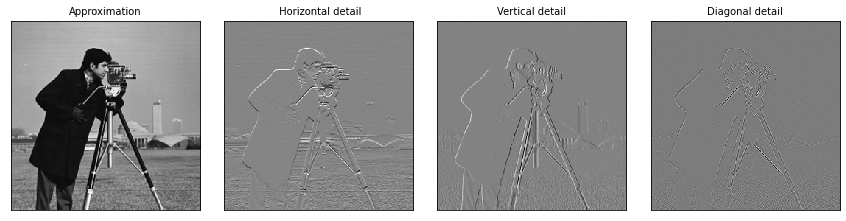

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
# sub_episode
# y

t = np.arange(len(sub_episode))/float(sr) # getting time
data = sub_episode/max(sub_episode)

# Approximation and detail coefficients.
cA, cD = pywt.dwt(data, 'bior6.8', 'per') #dwt

# Inverse Discrete Wavelet Transform (IDWT)
data_y = pywt.idwt(cA, cD, 'bior6.8', 'per')

In [ ]:
print(cA)
print(cD)
print(data_y)

[-4.9278736e-03  4.2146347e-03 -9.1512897e-04 ...  8.3191866e-05
 -3.0445869e-04  7.7679433e-04]
[ 1.4093758e-03 -4.7173383e-04  2.2622116e-03 ... -6.1405764e-05
  4.1723993e-04 -2.1967327e-03]
[-4.2565209e-03 -1.8842025e-03  3.8054464e-03 ... -9.3223207e-11
 -2.0372681e-10  1.0209078e-10]


In [ ]:
len(cA)

6074496

In [ ]:
cA_same_len = np.repeat(cA,2)
cD_same_len = np.repeat(cD,2)

In [ ]:
cA_same_len

array([-0.00492787, -0.00492787,  0.00421463, ..., -0.00030446,
        0.00077679,  0.00077679], dtype=float32)

In [ ]:
cD_same_len

array([ 0.00140938,  0.00140938, -0.00047173, ...,  0.00041724,
       -0.00219673, -0.00219673], dtype=float32)

In [ ]:
len(cD)

6074496

In [ ]:
len(data_y)

12148992

In [ ]:
#!pip install wavefile

In [ ]:
#from scipy.io import wavefile

#wavefile.write('testR.wave', sr, data_y)
#wavefile.write('testcD.wave', sr, cD)

# Augmentation

In [ ]:
%pip install audiomentations
%pip install pydub

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

SAMPLE_RATE = 16000

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


In [ ]:
augmented_samples = augment(samples=sub_episode, sample_rate=sr)

In [ ]:
augmented_samples

array([0.00137274, 0.00180598, 0.00925527, ..., 0.00101649, 0.00715622,
       0.00963128], dtype=float32)

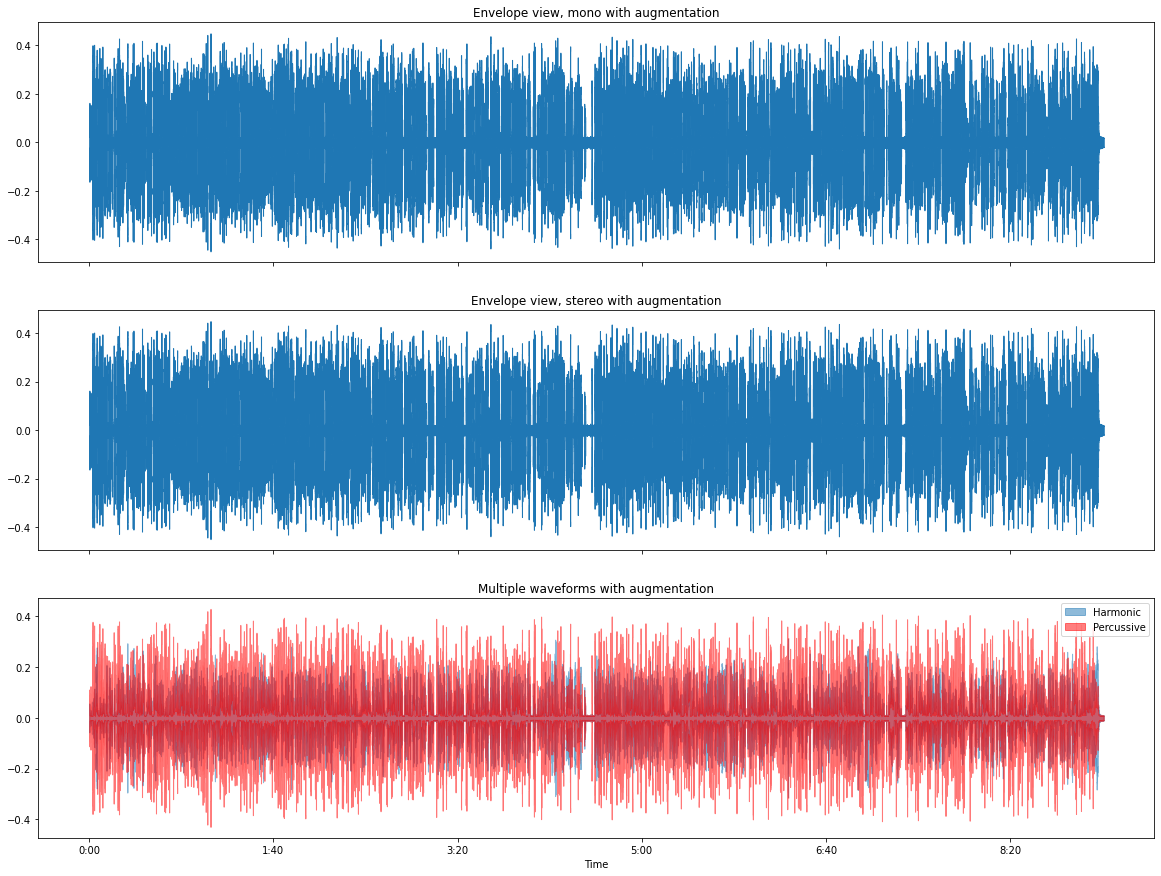

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize = (20,15))
librosa.display.waveshow(augmented_samples, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono with augmentation')
ax[0].label_outer()

librosa.display.waveshow(augmented_samples, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo with augmentation')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(augmented_samples)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms with augmentation')
ax[2].legend()

comparing with original graph without augmentation

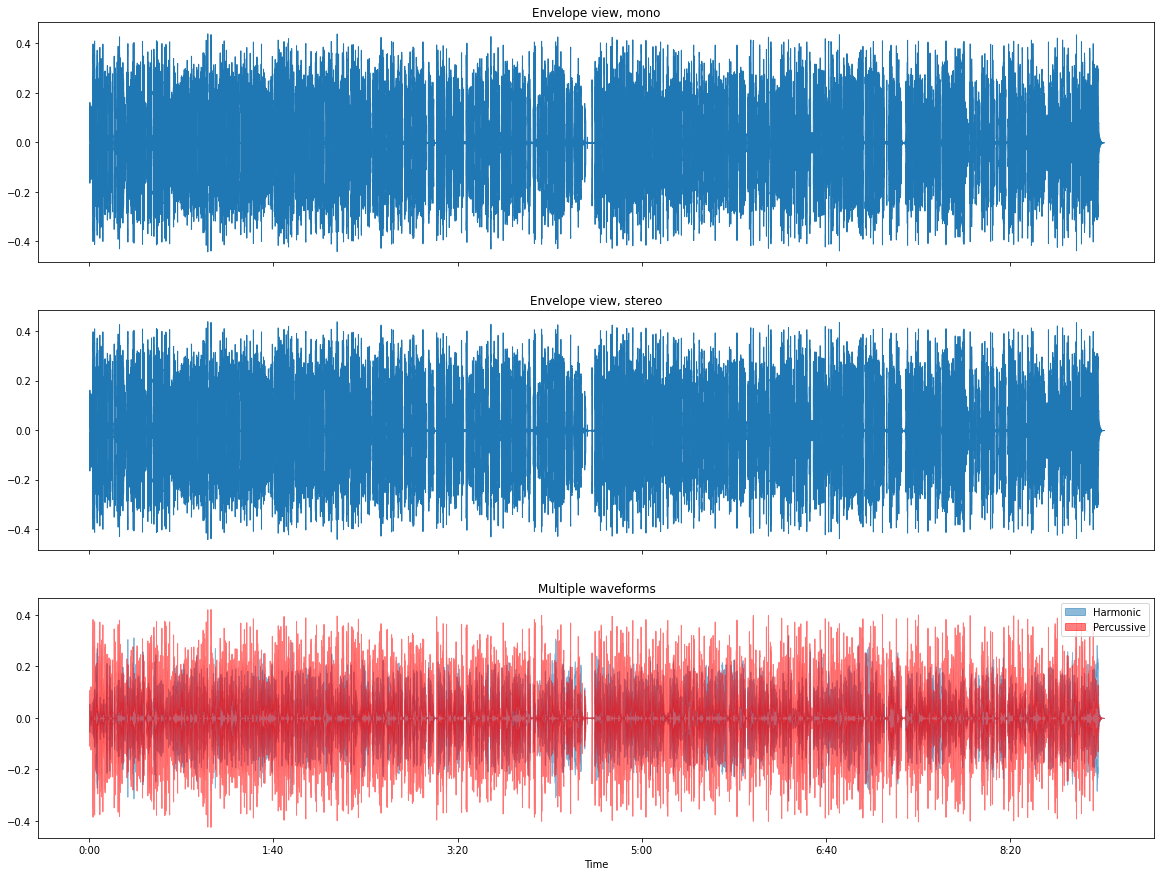

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize = (20,15))
librosa.display.waveshow(sub_episode, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

librosa.display.waveshow(sub_episode, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(sub_episode)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms')
ax[2].legend()

# Baseline Logistic Regression


In [ ]:
tempo, beats = librosa.beat.beat_track(augmented_samples, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)

In [ ]:
mean = np.mean(augmented_samples)
max = np.max(augmented_samples)
min = np.min(augmented_samples)

print(mean, max, min)

-2.677132e-07 0.25795835 -0.24792683


In [ ]:
time_stamp = librosa.samples_to_time(np.arange(0, len(augmented_samples)))

In [ ]:
len(augmented_samples)/sr

550.974693877551

In [ ]:
mean = np.mean(augmented_samples)
mean

-2.677132e-07

In [ ]:
y_harm, y_perc = librosa.effects.hpss(augmented_samples)

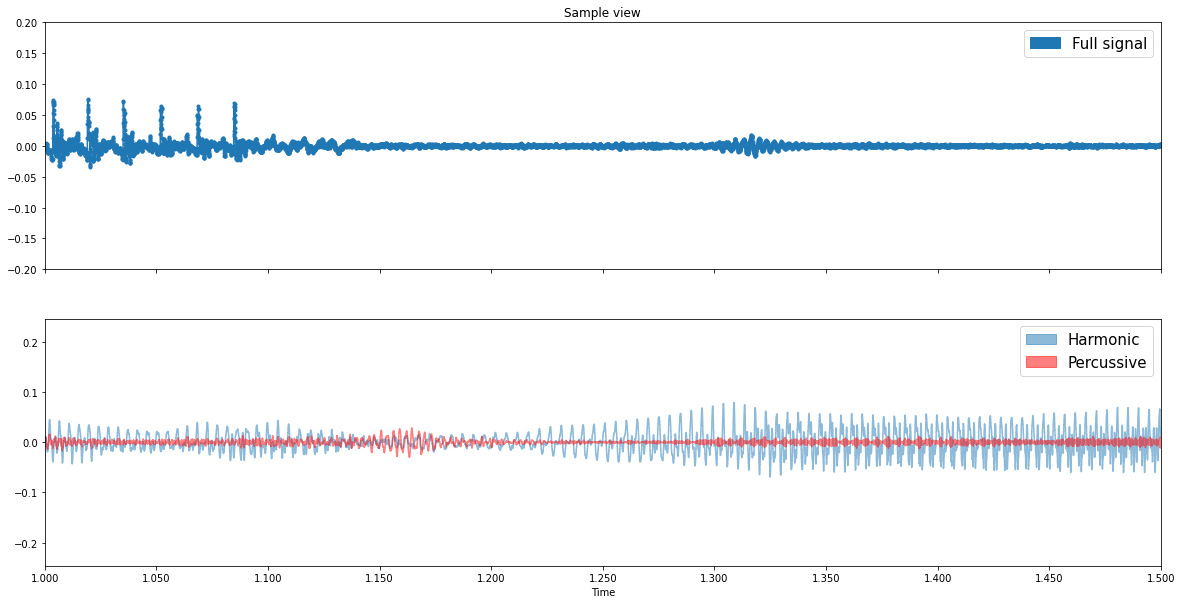

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize = (20,10))
ax.set(xlim=[1, 1.5], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(sub_episode, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.plot(mean, linestyle = 'dashed')
ax.label_outer()
ax.legend(fontsize=15)
ax2.legend(fontsize=15)

In [ ]:
df = pd.DataFrame()
df['time'] = time_stamp
df['original'] = sub_episode
df['augment_sample'] = augmented_samples
df['dwt_cA'] = cA_same_len
df['dwt_cD'] = cD_same_len

In [ ]:
df

,time,original,augment_sample,dwt_cA,dwt_cD
0,0.000000,-0.001871,0.001373,-0.004928,0.001409
1,0.000045,-0.000828,0.001806,-0.004928,0.001409
2,0.000091,0.001672,0.009255,0.004215,-0.000472
3,0.000136,0.001214,0.002124,0.004215,-0.000472
4,0.000181,-0.000078,0.001175,-0.000915,0.002262
...,...,...,...,...,...
12148987,550.974467,0.000000,0.005807,0.000083,-0.000061
12148988,550.974512,0.000000,-0.005501,-0.000304,0.000417
12148989,550.974558,0.000000,0.001016,-0.000304,0.000417
12148990,550.974603,0.000000,0.007156,0.000777,-0.002197


In [ ]:
df_aggregated = df.groupby(df.index // sr).mean()
variance = df.groupby(df.index // sr).var()

In [ ]:
df_aggregated

,time,original,augment_sample,dwt_cA,dwt_cD
0,0.499977,1.356442e-05,-0.000025,4.407460e-05,1.483946e-07
1,1.499977,1.182209e-05,0.000055,3.745397e-05,-5.225897e-08
2,2.499977,8.688703e-05,0.000136,2.793797e-04,-7.768563e-08
3,3.499977,-1.340378e-05,-0.000010,-5.553611e-05,-9.826528e-08
4,4.499977,-4.621403e-05,-0.000026,-1.398176e-04,5.699442e-08
...,...,...,...,...,...
546,546.499977,1.057341e-04,0.000145,3.405990e-04,-1.157678e-06
547,547.499977,-3.493342e-04,-0.000309,-1.115679e-03,1.647936e-06
548,548.499977,2.197616e-05,-0.000056,7.209962e-05,9.473634e-07
549,549.499977,7.677414e-08,0.000114,2.167833e-07,-1.093796e-07


In [ ]:
scaler = StandardScaler()
#scaler.fit(df_aggregated.augment_sample)
df_aggregated.original = scaler.fit_transform(df_aggregated.original.values.reshape(-1,1))
df_aggregated.augment_sample = scaler.fit_transform(df_aggregated.augment_sample.values.reshape(-1,1))
#df_aggregated.dwt = scaler.fit_transform(df_aggregated.dwt.values.reshape(-1,1))
df_aggregated['variance'] = variance.original.values.reshape(-1,1)
df_aggregated['dwt_cA'] = scaler.fit_transform(df_aggregated['dwt_cA'].values.reshape(-1,1))
df_aggregated['dwt_cD'] = scaler.fit_transform(df_aggregated['dwt_cD'].values.reshape(-1,1))


In [ ]:
df_aggregated

,time,original,augment_sample,dwt_cA,dwt_cD,variance
0,0.499977,0.353209,-0.469785,0.355581,0.063727,3.890658e-04
1,1.499977,0.308813,1.010374,0.303302,-0.023320,1.528526e-03
2,2.499977,2.221544,2.493705,2.213627,-0.034351,3.170917e-03
3,3.499977,-0.333968,-0.178968,-0.430978,-0.043278,4.561747e-03
4,4.499977,-1.170006,-0.486129,-1.096493,0.024076,4.349144e-03
...,...,...,...,...,...,...
546,546.499977,2.701787,2.670380,2.697035,-0.502870,6.790584e-03
547,547.499977,-8.893814,-5.686650,-8.802217,0.714254,6.263578e-03
548,548.499977,0.567549,-1.035507,0.576875,0.410333,5.335925e-05
549,549.499977,0.009530,2.086608,0.009265,-0.048100,8.204252e-07


In [ ]:
union_disagree = pd.read_csv('union_annotation.csv')
union_disagree

,Unnamed: 0,annotator,text,label,start,end
0,0,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,8.653260,10.253415
1,1,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,14.367289,18.004163
2,2,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,28.312520,30.462509
3,3,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,31.612503,34.062490
4,4,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,43.356610,46.862424
5,5,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,59.062362,61.412350
6,6,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,62.952381,63.402378
7,7,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,67.958985,80.312252
8,8,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,80.669196,81.619288
9,9,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,91.712194,102.312139


In [ ]:
def produce_label_y(start, end, timestamp):
    result = []
    for t in timestamp:
        flag = False
        for i,j in zip(start,end):
            if float(t)>=float(i) and float(t)<=float(j):
                result.append(1)
                flag = True
                break
            else:
                continue
        if not flag:
            result.append(0)
    return result

In [ ]:
result = produce_label_y(union_disagree.start, union_disagree.end, df_aggregated.time)

In [ ]:
df_aggregated['y'] = result
df_aggregated

,time,original,augment_sample,dwt_cA,dwt_cD,variance,y
0,0.499977,0.353209,-0.469785,0.355581,0.063727,3.890658e-04,0
1,1.499977,0.308813,1.010374,0.303302,-0.023320,1.528526e-03,0
2,2.499977,2.221544,2.493705,2.213627,-0.034351,3.170917e-03,0
3,3.499977,-0.333968,-0.178968,-0.430978,-0.043278,4.561747e-03,0
4,4.499977,-1.170006,-0.486129,-1.096493,0.024076,4.349144e-03,0
...,...,...,...,...,...,...,...
546,546.499977,2.701787,2.670380,2.697035,-0.502870,6.790584e-03,0
547,547.499977,-8.893814,-5.686650,-8.802217,0.714254,6.263578e-03,0
548,548.499977,0.567549,-1.035507,0.576875,0.410333,5.335925e-05,0
549,549.499977,0.009530,2.086608,0.009265,-0.048100,8.204252e-07,0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve
from sklearn.utils import resample

In [ ]:
X = df_aggregated[['original','augment_sample','variance','dwt_cA', 'dwt_cD']].values
y = df_aggregated['y'].values

In [ ]:
X_new, y_new = resample(X, y, n_samples=100000, replace=True, stratify = y, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24679
           1       0.00      0.00      0.00      5321

    accuracy                           0.82     30000
   macro avg       0.41      0.50      0.45     30000
weighted avg       0.68      0.82      0.74     30000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


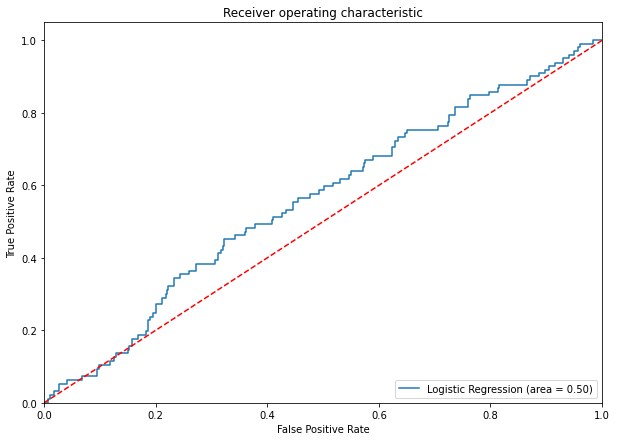

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()